In [1]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords 

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, StratifiedKFold

import keras
from keras.initializers import Constant
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras import optimizers

In [2]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
test_data = pd.read_csv('../input/nlp-getting-started/test.csv', dtype={'id': np.int16})

In [3]:
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [4]:
train_data.groupby('target').count()['id']

target
0    4342
1    3271
Name: id, dtype: int64

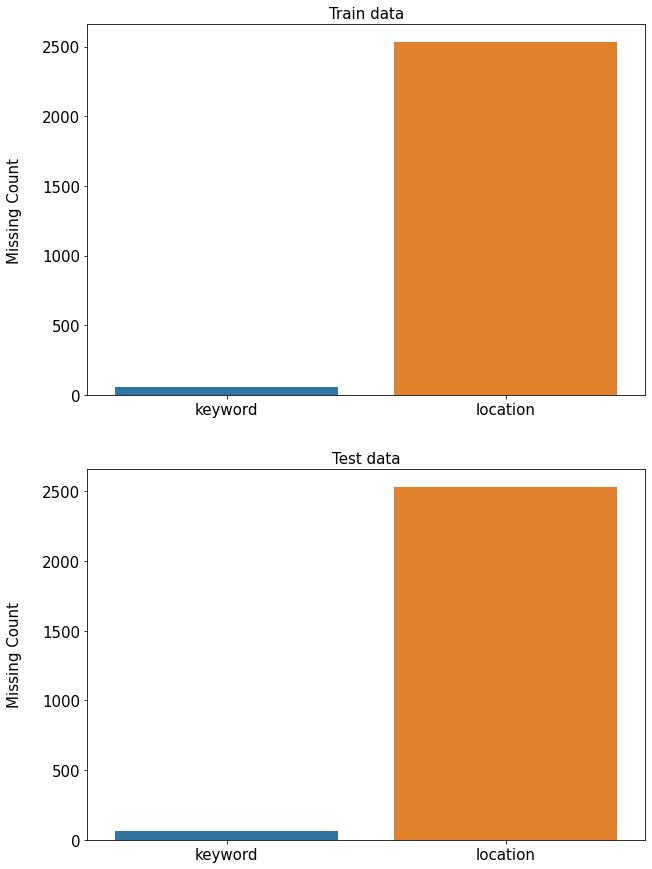

In [5]:
miss_cols = ['keyword', 'location']

fig, axes = plt.subplots(2,figsize=(10, 15))

sns.barplot(x=train_data[miss_cols].isnull().sum().index, y=train_data[miss_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=train_data[miss_cols].isnull().sum().index, y=train_data[miss_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].set_ylabel('Missing Count', size=15, labelpad=20)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Train data', fontsize=15)
axes[1].set_title('Test data', fontsize=15)

plt.show()

# for data in [train_data, test_data]:
#     for col in ['keyword', 'location']:
#         data[col] = data[col].fillna(f'no_{col}')

In [6]:
train_x = train_data['text'].copy()
train_y = train_data['target'].copy()

<AxesSubplot:xlabel='target', ylabel='count'>

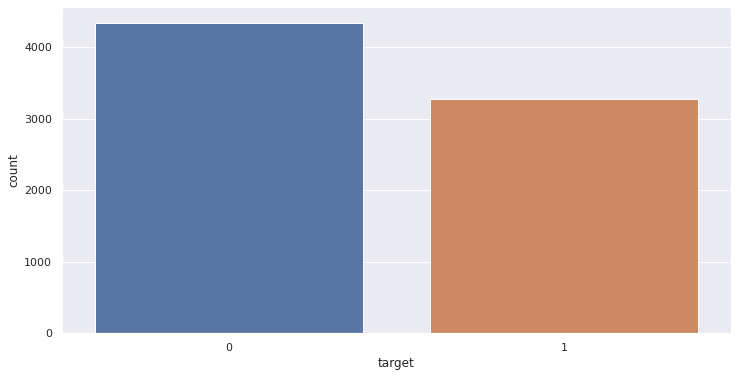

In [7]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(12,6)})
sns.countplot(train_y)

Cleaning

In [8]:
stop = stopwords.words('english')
def clean(text):
    
    text = re.sub(r'http\S+', ' ', text)
    
    text = re.sub(r'<.*?>', ' ', text)    
    
    text = re.sub(r'#\w+', ' ', text)    
     
    text = re.sub(r'@\w+', ' ', text)
    
    text = re.sub(r'\d+', ' ', text)
    
    text = text.split()
    
    text = ' '.join([word for word in text if word not in stop])
    
    return text

In [9]:
train_x_cleaned = train_x.apply(clean)
train_x_cleaned.head()

0                Our Deeds Reason May ALLAH Forgive us
1               Forest fire near La Ronge Sask. Canada
2    All residents asked 'shelter place' notified o...
3        , people receive evacuation orders California
4          Just got sent photo Ruby smoke pours school
Name: text, dtype: object

In [10]:
max_len = max(train_x_cleaned.apply(len))
print('max length: {}'.format(max_len))

max length: 141


Tokenize

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x_cleaned)
vocab_size = len(tokenizer.word_index) + 1
x = tokenizer.texts_to_sequences(train_x_cleaned)
x = pad_sequences(x, max_len, padding='post')
y = train_y
print('train_x_clean:', train_x_cleaned[4])
print('*'*50)
print('x:',x[5])
print('vocabulary size:{}'.format(vocab_size))

train_x_clean: Just got sent photo Ruby smoke pours school
**************************************************
x: [ 318   45 1367  772 6083  478 1112  319    6    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
vocabulary size:13947


In [12]:
x.shape

(7613, 141)

In [13]:
y.shape

(7613,)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=12, stratify=y)

Model

model1

In [15]:
epoch_size =10
batch_size = 32
embedding_dim = 16
optimizer = optimizers.Adam(lr=3e-4)

model = Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    layers.Bidirectional(layers.GRU(256, return_sequences=True)),
    layers.GlobalMaxPool1D(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(2, activation='sigmoid')
])
model.summary()

2022-07-19 07:29:47.709486: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 141, 16)           223152    
_________________________________________________________________
bidirectional (Bidirectional (None, 141, 512)          420864    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 676,978
Trainable params: 676,978
Non-trainable params: 0
__________________________________________________

In [16]:
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history = model.fit(x, y, epochs=epoch_size, validation_split=0.1)

Epoch 1/10


2022-07-19 07:29:48.398715: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


215/215 [==============================] - 82s 361ms/step - loss: 0.5953 - accuracy: 0.6850 - val_loss: 0.4751 - val_accuracy: 0.7966
Epoch 2/10
215/215 [==============================] - 78s 365ms/step - loss: 0.3588 - accuracy: 0.8574 - val_loss: 0.5348 - val_accuracy: 0.7717
Epoch 3/10
215/215 [==============================] - 77s 359ms/step - loss: 0.2269 - accuracy: 0.9164 - val_loss: 0.7470 - val_accuracy: 0.7336
Epoch 4/10
215/215 [==============================] - 77s 358ms/step - loss: 0.1488 - accuracy: 0.9483 - val_loss: 0.7848 - val_accuracy: 0.7375
Epoch 5/10
215/215 [==============================] - 77s 357ms/step - loss: 0.1159 - accuracy: 0.9584 - val_loss: 0.7719 - val_accuracy: 0.7690
Epoch 6/10
215/215 [==============================] - 77s 358ms/step - loss: 0.0976 - accuracy: 0.9648 - val_loss: 0.7142 - val_accuracy: 0.7559
Epoch 7/10
215/215 [==============================] - 77s 360ms/step - loss: 0.0807 - accuracy: 0.9692 - val_loss: 1.0279 - val_accuracy: 0.7

In [17]:
test_x = test_data['text'].copy()
test_x = test_x.apply(clean)
test_x = tokenizer.texts_to_sequences(test_x)
test_x = pad_sequences(test_x, max_len, padding='post')

In [18]:
test_pred = np.argmax(model.predict(test_x), axis=1)
print(test_pred)

[1 0 1 ... 1 1 1]


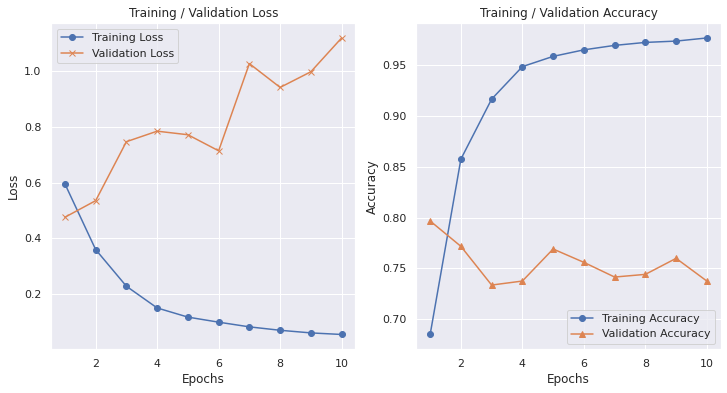

In [19]:
history1 = history.history

trg_loss = history1['loss']
val_loss = history1['val_loss']

trg_acc = history1['accuracy']
val_acc = history1['val_accuracy']

epochs = range(1, len(trg_acc) + 1)

# plot losses and accuracies for training and validation 
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(epochs, trg_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='x', label='Validation Loss')
plt.title("Training / Validation Loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend(loc='best')

ax = fig.add_subplot(1, 2, 2)
plt.plot(epochs, trg_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='^', label='Validation Accuracy')
plt.title("Training / Validation Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend(loc='best')
plt.show()

model 2

In [20]:
epoch_size =10
batch_size = 32
embedding_dim = 16
optimizer = optimizers.Adam(lr=3e-4)

model2 = Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    layers.Bidirectional(layers.GRU(256, return_sequences=True)),
    layers.GlobalMaxPool1D(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(2, activation='sigmoid')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 141, 16)           223152    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 141, 512)          420864    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 676,978
Trainable params: 676,978
Non-trainable params: 0
________________________________________________

In [21]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history = model2.fit(x, y, epochs=epoch_size, validation_split=0.1)

Epoch 1/10
215/215 [==============================] - 83s 367ms/step - loss: 0.7093 - accuracy: 0.6317 - val_loss: 0.4671 - val_accuracy: 0.7979
Epoch 2/10
215/215 [==============================] - 77s 359ms/step - loss: 0.4016 - accuracy: 0.8415 - val_loss: 0.4557 - val_accuracy: 0.7874
Epoch 3/10
215/215 [==============================] - 79s 367ms/step - loss: 0.2534 - accuracy: 0.9066 - val_loss: 0.4818 - val_accuracy: 0.7717
Epoch 4/10
215/215 [==============================] - 78s 362ms/step - loss: 0.1720 - accuracy: 0.9393 - val_loss: 0.5971 - val_accuracy: 0.7559
Epoch 5/10
215/215 [==============================] - 77s 356ms/step - loss: 0.1231 - accuracy: 0.9594 - val_loss: 0.7850 - val_accuracy: 0.7415
Epoch 6/10
215/215 [==============================] - 77s 360ms/step - loss: 0.0935 - accuracy: 0.9656 - val_loss: 0.7971 - val_accuracy: 0.7743
Epoch 7/10
215/215 [==============================] - 79s 366ms/step - loss: 0.0818 - accuracy: 0.9680 - val_loss: 0.8252 - val_ac

In [22]:
test_pred = np.argmax(model2.predict(test_x), axis=1)
print(test_pred)

[1 0 1 ... 1 1 1]


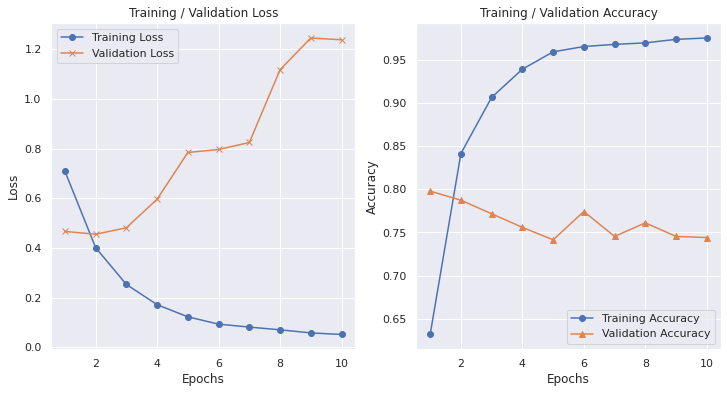

In [23]:
history2 = history.history

trg_loss = history2['loss']
val_loss = history2['val_loss']

trg_acc = history2['accuracy']
val_acc = history2['val_accuracy']

epochs = range(1, len(trg_acc) + 1)

# plot losses and accuracies for training and validation 
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(epochs, trg_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='x', label='Validation Loss')
plt.title("Training / Validation Loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend(loc='best')

ax = fig.add_subplot(1, 2, 2)
plt.plot(epochs, trg_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='^', label='Validation Accuracy')
plt.title("Training / Validation Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend(loc='best')
plt.show()

model 3

In [24]:
epoch_size =10
batch_size = 32
embedding_dim = 16
optimizer = optimizers.Adam(lr=3e-4)

model3 = Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_len, trainable=False),
    layers.SpatialDropout1D(0.2),

    layers.Bidirectional(layers.LSTM(64, recurrent_dropout=0.5, dropout=0.5, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64, recurrent_dropout=0.5, dropout=0.5)),

    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 141, 16)           223152    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 141, 16)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 141, 128)          41472     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 371,826
Trainable params: 148,674
Non-trainable params: 223,152
__________________________________________

In [25]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
history = model3.fit(x, y, epochs=epoch_size, validation_split=0.1)

Epoch 1/10
215/215 [==============================] - 254s 1s/step - loss: 0.6821 - accuracy: 0.5742 - val_loss: 0.6972 - val_accuracy: 0.5341
Epoch 2/10
215/215 [==============================] - 242s 1s/step - loss: 0.6811 - accuracy: 0.5744 - val_loss: 0.6889 - val_accuracy: 0.5341
Epoch 3/10
215/215 [==============================] - 239s 1s/step - loss: 0.6783 - accuracy: 0.5747 - val_loss: 0.6907 - val_accuracy: 0.5341
Epoch 4/10
215/215 [==============================] - 238s 1s/step - loss: 0.6755 - accuracy: 0.5733 - val_loss: 0.6855 - val_accuracy: 0.5341
Epoch 5/10
215/215 [==============================] - 240s 1s/step - loss: 0.6771 - accuracy: 0.5758 - val_loss: 0.6833 - val_accuracy: 0.5328
Epoch 6/10
215/215 [==============================] - 241s 1s/step - loss: 0.6748 - accuracy: 0.5720 - val_loss: 0.6823 - val_accuracy: 0.5341
Epoch 7/10
215/215 [==============================] - 238s 1s/step - loss: 0.6752 - accuracy: 0.5732 - val_loss: 0.6823 - val_accuracy: 0.5341

In [26]:
test_pred = np.argmax(model3.predict(test_x), axis=1)
print(test_pred)

[0 0 0 ... 0 0 0]


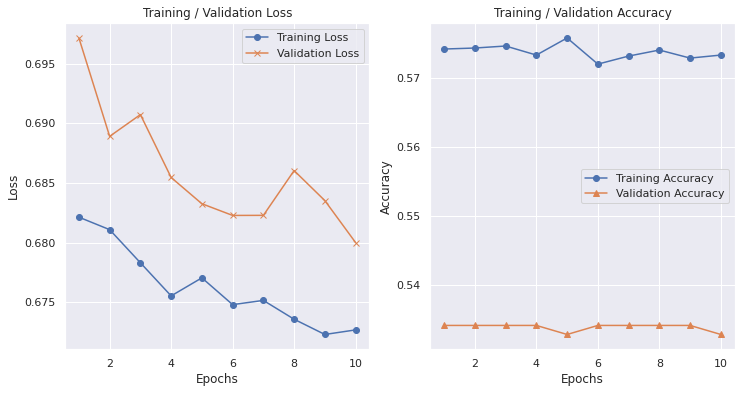

In [27]:
history3 = history.history

trg_loss = history3['loss']
val_loss = history3['val_loss']

trg_acc = history3['accuracy']
val_acc = history3['val_accuracy']

epochs = range(1, len(trg_acc) + 1)

# plot losses and accuracies for training and validation 
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(epochs, trg_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='x', label='Validation Loss')
plt.title("Training / Validation Loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend(loc='best')

ax = fig.add_subplot(1, 2, 2)
plt.plot(epochs, trg_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='^', label='Validation Accuracy')
plt.title("Training / Validation Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend(loc='best')
plt.show()

model 4

In [28]:
epoch_size =10
batch_size = 32
embedding_dim = 16
optimizer = optimizers.Adam(lr=3e-4)

model4 = Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    layers.Bidirectional(layers.GRU(256, return_sequences=True)),
    layers.GlobalMaxPool1D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(2, activation='sigmoid')
])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 141, 16)           223152    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 141, 512)          420864    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

In [29]:
model4.compile(loss='sparse_categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
history = model4.fit(x, y, epochs=epoch_size, validation_split=0.2)

Epoch 1/10
191/191 [==============================] - 76s 380ms/step - loss: 0.6804 - accuracy: 0.5782 - val_loss: 0.6750 - val_accuracy: 0.5345
Epoch 2/10
191/191 [==============================] - 71s 374ms/step - loss: 0.5047 - accuracy: 0.7658 - val_loss: 0.4912 - val_accuracy: 0.7794
Epoch 3/10
191/191 [==============================] - 71s 372ms/step - loss: 0.3472 - accuracy: 0.8750 - val_loss: 0.5247 - val_accuracy: 0.7406
Epoch 4/10
191/191 [==============================] - 71s 372ms/step - loss: 0.2397 - accuracy: 0.9138 - val_loss: 0.5561 - val_accuracy: 0.7380
Epoch 5/10
191/191 [==============================] - 71s 374ms/step - loss: 0.1667 - accuracy: 0.9435 - val_loss: 0.6465 - val_accuracy: 0.7485
Epoch 6/10
191/191 [==============================] - 71s 371ms/step - loss: 0.1359 - accuracy: 0.9544 - val_loss: 0.7128 - val_accuracy: 0.7295
Epoch 7/10
191/191 [==============================] - 71s 374ms/step - loss: 0.1127 - accuracy: 0.9622 - val_loss: 0.7951 - val_ac

In [30]:
test_pred = np.argmax(model2.predict(test_x), axis=1)
print(test_pred)

[1 0 1 ... 1 1 1]


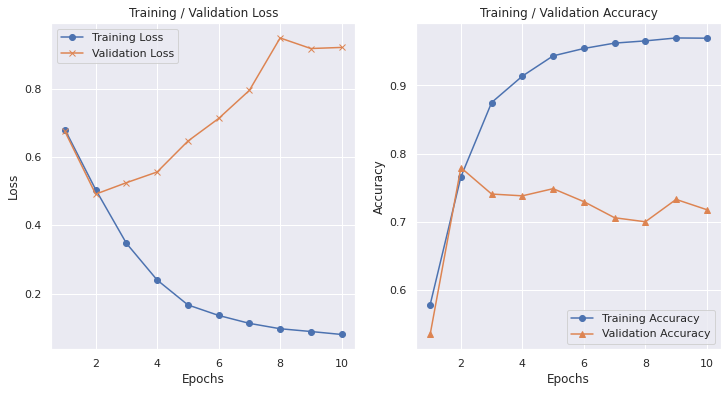

In [31]:
history4 = history.history

trg_loss = history4['loss']
val_loss = history4['val_loss']

trg_acc = history4['accuracy']
val_acc = history4['val_accuracy']

epochs = range(1, len(trg_acc) + 1)

# plot losses and accuracies for training and validation 
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(epochs, trg_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='x', label='Validation Loss')
plt.title("Training / Validation Loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend(loc='best')

ax = fig.add_subplot(1, 2, 2)
plt.plot(epochs, trg_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='^', label='Validation Accuracy')
plt.title("Training / Validation Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend(loc='best')
plt.show()

model5

In [32]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('../input/glove6b100dtxt/glove.6B.100d.txt', encoding='UTF8')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [33]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [34]:
from tensorflow.keras.layers import LSTM
epoch_size =10
batch_size = 32
# embedding_dim = 16

model5 = Sequential([
    layers.Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix]
                        ),
    layers.Bidirectional(LSTM(64, return_sequences = True, recurrent_dropout=0.2)),
    layers.GlobalMaxPool1D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1394700   
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 128)         84480     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [35]:
from tensorflow.keras.optimizers import RMSprop
model5.compile(loss='binary_crossentropy', optimizer = RMSprop(learning_rate=0.0001), metrics=['accuracy'])
history5 = model5.fit(x, y, epochs=epoch_size, validation_split=0.2)

Epoch 1/10
191/191 [==============================] - 127s 629ms/step - loss: 0.8860 - accuracy: 0.5453 - val_loss: 0.6503 - val_accuracy: 0.7255
Epoch 2/10
191/191 [==============================] - 118s 620ms/step - loss: 0.7429 - accuracy: 0.6146 - val_loss: 0.5620 - val_accuracy: 0.7715
Epoch 3/10
191/191 [==============================] - 119s 623ms/step - loss: 0.6883 - accuracy: 0.6491 - val_loss: 0.4975 - val_accuracy: 0.7853
Epoch 4/10
191/191 [==============================] - 119s 625ms/step - loss: 0.6294 - accuracy: 0.6916 - val_loss: 0.4732 - val_accuracy: 0.7938
Epoch 5/10
191/191 [==============================] - 119s 626ms/step - loss: 0.5978 - accuracy: 0.7103 - val_loss: 0.4616 - val_accuracy: 0.7951
Epoch 6/10
191/191 [==============================] - 118s 618ms/step - loss: 0.5952 - accuracy: 0.7197 - val_loss: 0.4536 - val_accuracy: 0.7925
Epoch 7/10
191/191 [==============================] - 120s 628ms/step - loss: 0.5647 - accuracy: 0.7307 - val_loss: 0.4469 -

In [36]:
test_pred = np.argmax(model5.predict(test_x), axis=1)
print(test_pred)

[0 0 0 ... 0 0 0]


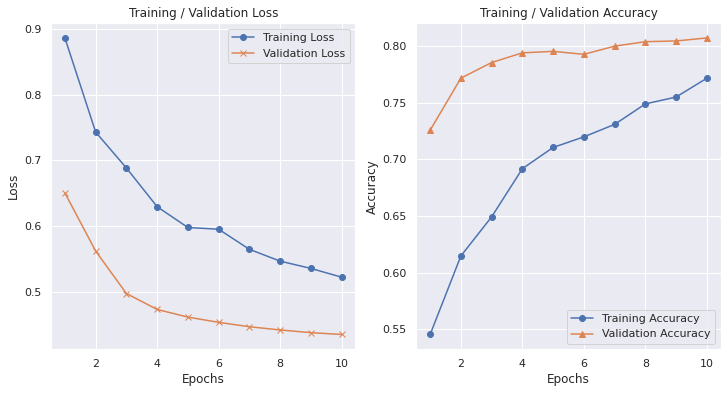

In [37]:
history = history5.history

trg_loss = history['loss']
val_loss = history['val_loss']

trg_acc = history['accuracy']
val_acc = history['val_accuracy']

epochs = range(1, len(trg_acc) + 1)

# plot losses and accuracies for training and validation 
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(epochs, trg_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='x', label='Validation Loss')
plt.title("Training / Validation Loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend(loc='best')

ax = fig.add_subplot(1, 2, 2)
plt.plot(epochs, trg_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='^', label='Validation Accuracy')
plt.title("Training / Validation Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend(loc='best')
plt.show()

model 6

In [38]:
epoch_size =10
batch_size = 32
# embedding_dim = 16

model6 = Sequential([
    layers.Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix]
                        ),
    layers.Bidirectional(layers.GRU(256, return_sequences=True)),
    layers.GlobalMaxPool1D(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(2, activation='sigmoid')
])
model6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1394700   
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 512)         549888    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 130       
Total params: 1,977,550
Trainable params: 1,977,550
Non-trainable params: 0
____________________________________________

In [39]:
model6.compile(loss='sparse_categorical_crossentropy', optimizer = RMSprop(learning_rate=0.0001), metrics=['accuracy'])
history6 = model6.fit(x, y, epochs=epoch_size, validation_split=0.1)

Epoch 1/10
215/215 [==============================] - 92s 410ms/step - loss: 0.5502 - accuracy: 0.7336 - val_loss: 0.4709 - val_accuracy: 0.7979
Epoch 2/10
215/215 [==============================] - 86s 401ms/step - loss: 0.4629 - accuracy: 0.7939 - val_loss: 0.4445 - val_accuracy: 0.8071
Epoch 3/10
215/215 [==============================] - 86s 399ms/step - loss: 0.4364 - accuracy: 0.8110 - val_loss: 0.4407 - val_accuracy: 0.8018
Epoch 4/10
215/215 [==============================] - 86s 401ms/step - loss: 0.4234 - accuracy: 0.8162 - val_loss: 0.4329 - val_accuracy: 0.8058
Epoch 5/10
215/215 [==============================] - 87s 405ms/step - loss: 0.4072 - accuracy: 0.8267 - val_loss: 0.4347 - val_accuracy: 0.8097
Epoch 6/10
215/215 [==============================] - 86s 398ms/step - loss: 0.4005 - accuracy: 0.8320 - val_loss: 0.4422 - val_accuracy: 0.8123
Epoch 7/10
215/215 [==============================] - 85s 396ms/step - loss: 0.3897 - accuracy: 0.8356 - val_loss: 0.4404 - val_ac

In [40]:
test_pred = np.argmax(model6.predict(test_x), axis=1)
print(test_pred)

[1 0 1 ... 1 1 0]


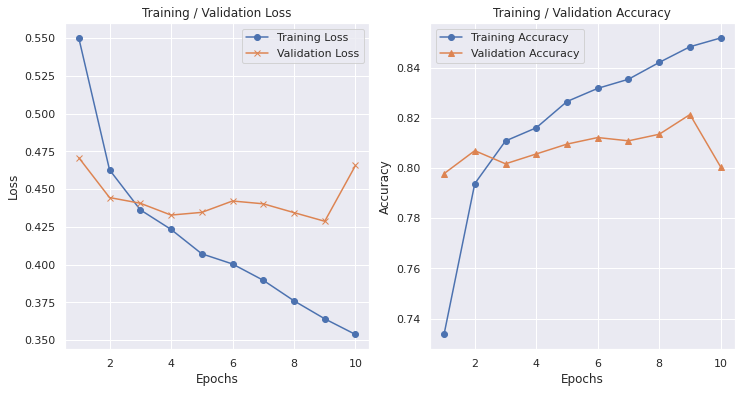

In [41]:
history = history6.history

trg_loss = history['loss']
val_loss = history['val_loss']

trg_acc = history['accuracy']
val_acc = history['val_accuracy']

epochs = range(1, len(trg_acc) + 1)

# plot losses and accuracies for training and validation 
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(epochs, trg_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='x', label='Validation Loss')
plt.title("Training / Validation Loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend(loc='best')

ax = fig.add_subplot(1, 2, 2)
plt.plot(epochs, trg_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='^', label='Validation Accuracy')
plt.title("Training / Validation Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend(loc='best')
plt.show()

create submission

In [42]:
submission = pd.DataFrame({'id':test_data['id'], 'target':test_pred})
submission.to_csv('submission.csv', index=False)